In [10]:
import pandas as pd
import urllib.request
from datetime import datetime
from datetime import datetime, timedelta 
import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import urllib.request
import tarfile
import shapely
from shapely import wkt

In [11]:
date = datetime.today() + timedelta(days=1) 
date = date.strftime('%Y-%m-%d')

date1 = datetime.today() - timedelta(days=10) 
date1 = date1.strftime('%Y-%m-%d')

url = urllib.request.urlretrieve('https://mesonet.agron.iastate.edu/cgi-bin/request/gis/lsr.py?&sts='+date1+'T00:00Z&ets='+date+'T00:00Z&fmt=csv', r'report.csv')



df = pd.read_csv('report.csv', on_bad_lines='skip')


In [12]:
#Fill remark column with '' in place of Nans
df['TYPETEXT'] = df['TYPETEXT'].fillna('')


#df = df.dropna()
df = df[df['TYPETEXT'].str.contains("FLOOD")]
df = df[~df['TYPETEXT'].str.contains("FLASH FLOOD")]
df = df[~df['TYPETEXT'].str.contains("COASTAL FLOOD")]
df = df[df.LON > -130]
df = df[df.LON < -50]

df['LAT'] = df['LAT'].astype(float)
df = df[df.LAT > 20.00]

In [13]:
#Needs work, script is not actually filtering the LSRs



#Filter to find most likely river flooding events.
#df =  df[df['REMARK'].str.contains("closed|river|River")]
#df =  df[df['REMARK'].str.contains("River")]
#df.to_csv("River_Only.csv")

import re
# Remove column name 'MAG'
df.drop(['MAG'], axis=1)

keywords = ["River", "stream", "overbank", "creek", "Creek", "Bayou", "bayou", "Banks", "banks", "Bank", "bank", "gage", "Gage", "road"]
# Function to check if any word in a text is in the list of keywords
# Create a regular expression pattern from the list of keywords
pattern = '|'.join(keywords)

#Fill remark column with '' in place of Nans
df['REMARK'] = df['REMARK'].fillna('')


# Search for rows containing any of the keywords
df = df[df['REMARK'].str.contains(pattern, flags=re.IGNORECASE)]

df.to_csv("River_Only.csv")

In [14]:
#Create geodataframe
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.LON, df.LAT), crs="EPSG:4326")

#Change Projection
gdf = gdf.to_crs(epsg=3857)

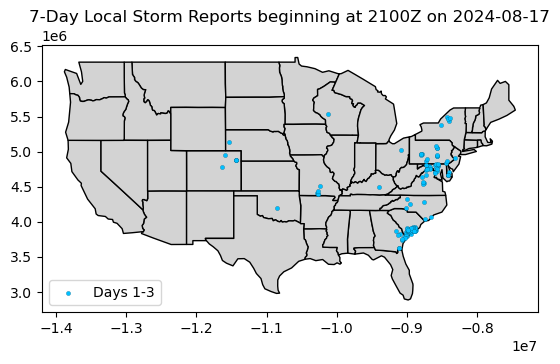

In [15]:
contiguous_usa = gpd.read_file(geoplot.datasets.get_path('contiguous_usa'),projection=gcrs.AlbersEqualArea())
#contiguous_usa = contiguous_usa[contiguous_usa.state.isin(['Missouri', 'Oklahoma', 'Kansas', 'Texas', 'Louisiana', 'Illinois', "Kentucky", 'Tennessee', 'Arkansas', 'Mississippi', 'Louisiana'])]

#Change Projection
contiguous_usa = contiguous_usa.to_crs(epsg=3857)

ax = contiguous_usa.plot(
    color='lightgray', edgecolor='black')


gdf.plot(ax=ax, color='deepskyblue',   markersize=10, edgecolors='black', linewidths=.1, label='Days 1-3')
ax.legend(loc="lower left")
ax.set_title('7-Day Local Storm Reports beginning at 2100Z on ' + date)

#plt.show()
plt.savefig('lsr_'+date+'.png', dpi=1000)

In [16]:
df['REMARK']=df['REMARK'].astype(str)


In [17]:
#This will download the latest ahps shapefile

#Download data and save the zipped shapefile
urllib.request.urlretrieve('https://water.noaa.gov/resources/downloads/shapefiles/national_shapefile_fcst_ffep.tgz', r'ahps.tgz')

#The file is zipped so now we have to unzip the file like we normally do with an AHPS Shapefile
fname = 'ahps.tgz'
if fname.endswith("ahps.tgz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()
elif fname.endswith("tar"):
    tar = tarfile.open(fname, "r:")
    tar.extractall()
    tar.close()


In [18]:
#Every shapefile has a dbf file which is a table.We can now read that table and create a Pandas Dataframe with it.  
table = gpd.read_file(r'national_shapefile_fcst_ffep.dbf')
ahps = pd.DataFrame(table)
#This will save it if you want to. It may be good to look at.
ahps.to_csv('ahps.csv')
#View the table just by using this line
#ahps

In [19]:
# Convert the ahps DataFrame to a GeoDataFrame, adding a geometry column from the 'Latitude' and 'Longitude' columns
# We're converting the ahps DataFrame to a GeoDataFrame with point geometries to enable spatial operations

ahps = gpd.GeoDataFrame(ahps, geometry=gpd.points_from_xy(ahps.Longitude, ahps.Latitude), crs="EPSG:4326")

#Change Projection
ahps = ahps.to_crs(epsg=3857)

# Perform a spatial join between the GeoDataFrame gdf and the GeoDataFrame ahps, 
# keeping only the nearest match from ahps for each geometry in gdf.
# This finds the nearest gage (point) for each geometry in gdf
gdf_joined = gpd.sjoin_nearest(gdf, ahps, how='left')

# Create a copy of the resulting GeoDataFrame gdf_joined
# Creating a copy ensures that modifications to gdf won't affect gdf_joined
gdf = gdf_joined.copy()

# Convert the 'Latitude' and 'Longitude' columns to string data type
# This conversion might be necessary for later string operations
gdf = gdf.astype({'Latitude': 'str', 'Longitude': 'str'})

# Create a new column 'geometry_ahps' by concatenating the 'Longitude' and 'Latitude' columns 
# and forming a Well-Known Text (WKT) representation of a point geometry
# This creates a WKT representation of point geometries from the 'Latitude' and 'Longitude' columns
gdf['geometry_ahps'] = "POINT ("+ gdf['Longitude']+" "+gdf['Latitude']+")"

# Convert the 'geometry_ahps' column from WKT representation to Shapely geometries
# Convert WKT strings to Shapely Point geometries
gdf['geometry_ahps'] = gdf['geometry_ahps'].apply(wkt.loads)

In [20]:
# Create a GeoSeries from the 'geometry_ahps' column and set its CRS to EPSG:4326
gdf['geometry_ahps'] = gpd.GeoSeries(gdf['geometry_ahps'], crs="EPSG:4326")

# Ensure both geometry columns have the same CRS
if gdf.crs != gdf['geometry_ahps'].crs:
    gdf['geometry_ahps'] = gdf['geometry_ahps'].to_crs(gdf.crs)

In [21]:
# Calculate the distance between the 'geometry' and 'geometry_ahps' for each row in the GeoDataFrame
# and store the result in a new column named 'distance'
# This calculates the distance between each geometry in gdf and its corresponding geometry in 'geometry_ahps'
gdf["distance"] = gdf.apply(lambda row: row["geometry"].distance(row["geometry_ahps"]), axis=1)

# Convert the distance from meters to miles and store the result in a new column named 'distance_miles'
# Convert distances from meters to miles for convenience
gdf["distance_miles"] = gdf["distance"]/1609

#This will give us all the LSRs within 5 miles of a gage, which might be a good place to start.
gdf = gdf[gdf['distance_miles'] < 5]

gdf.to_csv('delete.csv')

In [22]:
# Get USGS ID, this adds the usgs id which we will use to go to the usgs pages and pull the past #river stages and such

#Download data and save the zipped shapefile
#This was updated on 08/16/2024 to pull from NWPS rather than AHPS
urllib.request.urlretrieve('https://water.noaa.gov/resources/downloads/reports/nwps_all_gauges_report.csv',r'nwps_all_gauges_report.csv')


# Read the HTML table from the provided URL into a DataFrame
# This table  contains information about AHPS (Advanced Hydrologic Prediction Service) site
#table = 'https://water.weather.gov/monitor/ahpsreport.php'
ahps = pd.read_csv('nwps_all_gauges_report.csv')

# Select the first table from the list of tables extracted from the HTML page (No longer needed if not pulling from HTML)
#ahps = ahps[0]

# Drop rows where the 'usgs id' column is NaN (missing)
# This is likely to remove rows where USGS IDs are not available, as they are needed to retrieve data
ahps = ahps[ahps['usgs id'].notna()]

# Create a new column 'GaugeLID' and set it equal to the values in the 'nws shef id' column
# Convert the values to strings and convert them to uppercase
ahps['GaugeLID'] = ahps['nws shef id']
ahps['GaugeLID'] = ahps['GaugeLID'].astype(str)
ahps['GaugeLID'] = ahps['GaugeLID'].str.upper()

# Keep only the 'GaugeLID' and 'usgs id' columns in the DataFrame
# This is to retain only the necessary information for merging with the main DataFrame gdf
ahps = ahps[['GaugeLID', 'usgs id']]

# Merge the main DataFrame gdf with the ahps DataFrame on the 'GaugeLID' column, using a left join
# This adds the USGS ID information to the main DataFrame gdf based on the 'GaugeLID' column
gdf = pd.merge(gdf, ahps, how='left', on="GaugeLID")


In [23]:
# Convert the 'datetime_column' to datetime format for begin date.
gdf['begin_date'] = pd.to_datetime(gdf['VALID2'], format='%Y/%m/%d %H:%M')
gdf['begin_date']=gdf['begin_date']- pd.to_timedelta(1, unit='d')
gdf['begin_date']=gdf['begin_date'].dt.strftime('%Y-%m-%d')

# Convert the 'datetime_column' to datetime format for end date.
gdf['end_date'] = pd.to_datetime(gdf['VALID2'], format='%Y/%m/%d %H:%M')
gdf['end_date']=gdf['end_date']+ pd.to_timedelta(1, unit='d')
gdf['end_date']=gdf['end_date'].dt.strftime('%Y-%m-%d')

In [24]:
#gdf = gdf.head(100)

In [25]:
#This goes to the USGS pages and pulls the data I can see some adjustments here though. 
#The begin_date and end_dates will probably just be the date of the LSR. This is from another #code so it may take some work

def return_status(gdf):  
    try:    
        site = gdf['usgs id']
        begin_date =gdf['begin_date']
        end_date =gdf['end_date']

        action = gdf['Action']
        minor = gdf['Flood']
        moderate = gdf['Moderate']
        major = gdf['Major']


        action = float(action)
        minor = float(minor)
        mod = float(moderate)
        major = float(major)


        table = 'https://nwis.waterdata.usgs.gov/usa/nwis/uv/?cb_00065=on&format=rdb&site_no='+site+'&period=&begin_date='+begin_date +'&end_date='+end_date
        df = pd.read_fwf(table, comment='#')
        df = df.iloc[1:,0].str.split("\t", expand = True)
        df.rename(columns={0:'Agency', 1:'USGSstationID', 2:'Date', 4:'Stage'}, inplace=True)
        df['Stage'] = df['Stage'].apply(pd.to_numeric, errors='coerce').dropna()
        df['Date1'] = pd.to_datetime(df['Date'])

        df['date'] = df['Date1'].dt.strftime('%Y-%m-%d, %H'+'00')


        df = df.reset_index()




        def f(df):
            if df['Stage'] < action:
                val = 'none'
            elif df['Stage'] < minor and action == 0:
                val = 'none'
            elif action < df['Stage'] < minor:
                val = 'action'
            elif action < df['Stage'] and minor == 0 and mod == 0 and major == 0 and action != 0:
                val = 'action'
            elif minor < df['Stage'] < mod:
                val = 'minor'
            elif minor < df['Stage'] and mod == 0 and major == 0 and minor != 0:
                val = 'minor'
            elif mod < df['Stage'] < major:
                val = 'moderate'     
            elif mod < df['Stage'] and major == 0 and mod != 0:
                val = 'moderate'
            elif major < df['Stage'] and major != 0:
                val = 'major'
            else:
                val = 'none'      
            return val,

        df[['status']] = df.apply(f,axis=1,result_type="expand")
        max_row =  df.loc[df['Stage'].idxmax()]
        max_stage = max_row['Stage']
        max_status = max_row['status']
        max_date = max_row['date']

        return max_stage, max_status, max_date,

    except:
        return 'error: USGS', 'error: USGS','error: USGS',
,
    
gdf[['Max stage (ft)', 'Max status', 'Max date']] = gdf.apply(return_status,axis=1,result_type="expand") 


In [26]:
gdf.to_csv('delete.csv')

In [27]:
#08/16/2024 Fixed the code that was previously pulling the river forecasts from AHPS. Updated to NWPS.




